In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

In [2]:
clinical_csv_path = Path(r'H:\Data\DR_AMC_data\DEEPRISK-DISTANT-database.csv')
clinical_df = pd.read_csv(clinical_csv_path, sep=';')
clinical_df = clinical_df.loc[clinical_df['Full_data'] == 'Yes']
print(len(clinical_df))

920


In [3]:
pid_mdn_df = pd.read_csv(r'H:\Data\DR_AMC_data\KEYFILE_SELECTED.csv')
pid_to_mdn = {row['PatientID']: row['MDN'] for _, row in pid_mdn_df.iterrows()}

mdn_draumc_df = pd.read_excel(r'H:\Data\DR_AMC_data\MDN_TO_PATIENTID.xlsx', header=None)
mdn_to_draumc = {row[0]: row[1] for _, row in mdn_draumc_df.iterrows()}

max_draumc = np.max([int(draumc[-4:]) for draumc in mdn_to_draumc.values()])

pid_to_draumc = {}
for pid, mdn in pid_to_mdn.items():
    if mdn in mdn_to_draumc:
        pid_to_draumc[pid] = mdn_to_draumc[mdn]
    else:
        max_draumc += 1
        draumc = f'DRAUMC{max_draumc:04d}'
        pid_to_draumc[pid] = draumc

print(pid_mdn_df)
pid_mdn_draumc_df = pid_mdn_df.copy()
pid_mdn_draumc_df['DRAUMC'] = pid_mdn_draumc_df['PatientID'].map(pid_to_draumc)
print(pid_mdn_draumc_df)
pid_mdn_draumc_df.to_excel(r'H:\Data\DR_AMC_data\DISTANT_DR_KEYFILE.xlsx', index=False)

clinical_df['Patientnumber'] = clinical_df['Patientnumber'].map(pid_to_draumc)
clinical_df.to_csv(r'H:\Data\DR_AMC_data\DR_DISTANT_clinical.csv', index=False)

     PatientID      MDN
0            2  7815921
1           17  1626078
2           18  5894954
3           60  3979798
4           77  4716124
..         ...      ...
915      26220  1938777
916      26231  8638944
917      26433  1848390
918      27393  1928761
919      27422  7866446

[920 rows x 2 columns]
     PatientID      MDN      DRAUMC
0            2  7815921  DRAUMC2807
1           17  1626078  DRAUMC2392
2           18  5894954  DRAUMC2203
3           60  3979798  DRAUMC2801
4           77  4716124  DRAUMC2407
..         ...      ...         ...
915      26220  1938777  DRAUMC2853
916      26231  8638944  DRAUMC2673
917      26433  1848390  DRAUMC2562
918      27393  1928761  DRAUMC2873
919      27422  7866446  DRAUMC2821

[920 rows x 3 columns]


In [4]:
ecg_csv_path = Path(r'H:\Data\DR_AMC_data\studyIDpatientID.csv')

df = pd.read_csv(ecg_csv_path)
print(df)

            Filename   PatientID  LastName AcquisitionDate AcquisitionTime  \
0       DRAUMC2000_1  DRAUMC2000       NaN      10-21-2011        10:11:38   
1       DRAUMC2001_1  DRAUMC2001       NaN      09-24-2013        09:52:46   
2       DRAUMC2002_1  DRAUMC2002       NaN      06-12-2014        14:38:16   
3       DRAUMC2003_1  DRAUMC2003       NaN      07-09-2012        00:20:34   
4       DRAUMC2004_1  DRAUMC2004       NaN      10-03-2012        11:13:00   
...              ...         ...       ...             ...             ...   
16053   DRAUMC2699_6  DRAUMC2699       NaN      10-06-2016        13:40:33   
16054  DRAUMC2362_79  DRAUMC2362       NaN      10-13-2017        10:07:24   
16055  DRAUMC2078_49  DRAUMC2078       NaN      02-01-2017        16:16:32   
16056  DRAUMC2200_80  DRAUMC2200       NaN      12-20-2016        13:59:39   
16057  DRAUMC2062_28  DRAUMC2062       NaN      12-30-2020        14:19:17   

      SiteName  PatientAge AgeUnits  Gender  Height  ...  QTInt

In [45]:
import numpy as np

In [69]:
def calc_days_before_implant(ecg_df, clinical_df):
    """
    Calculates the number of days between ICD implantation date and ECG recording.

    Args:
        ecg_df (pandas.DataFrame): DataFrame object with columns 'StudyDate' and
            'PatientID' for all ECGs.
        clinical_df (pandas.DataFrame): DataFrame object with columns 'SubjectID'
            and 'Date_ICD_implantatie' for all patients

    Returns:
        pandas.Series: Column with number of days untill ICD implantation date
            for each ECG.
    """
    # Get the implantation dates
    implantation_date = clinical_df[['Patientnumber', 'Date_of_implantation']].set_index('Patientnumber')
    implantation_date['Date_of_implantation'] = pd.to_datetime(implantation_date['Date_of_implantation'])
    implantation_dict = implantation_date.to_dict()['Date_of_implantation']
    # Get the ECG study dates
    ecg_dates = pd.to_datetime(ecg_df['AcquisitionDate'], format='%m-%d-%Y')
    # Calculate the time between implantation and ECG study
    ecg_time_before_implant = ecg_df['PatientID'].map(implantation_dict) - ecg_dates
    # Convert time to integer number of days
    ecg_time_before_implant = ecg_time_before_implant.apply(lambda x: x.days)
    return ecg_time_before_implant

def dict_fill_defaults(dictionary, keys, default=0):
    """
    Fills a dictionary with default value for each key in 'keys' that is not
        present.

    Args:
        dictionary (dict): Dictionary to be filled.
        keys (iterable): Keys which must either be present in dictionary or which
            should otherwise be added with a default value.
        default: Any hashable type that serves as default value.

    Returns:
        dictionary: Filled dictionary.
    """
    filled_dict = {key: dictionary.get(key, default) for key in keys}
    return filled_dict

def merge_ecg_and_clinical_df(ecg_df, clinical_df):
    """
    Extends a copy of 'clinical_df' with information regarding number of
        available ECGs for each patient.

    Args:
        ecg_df (pandas.DataFrame): DataFrame object with columns 'StudyDate' and
            'PatientID' for all ECGs.
        clinical_df (pandas.DataFrame): DataFrame object with columns 'SubjectID'
            and 'Date_ICD_implantatie' for all patients

    Returns:
        pandas.DataFrame: Extended copy of 'clinical_df'.
    """
    merged_df = clinical_df
    # Add the total number of ECGs per patient
    num_ecgs = ecg_df['PatientID'].value_counts().to_dict()
    merged_df['NumEcgsTotal'] = clinical_df['Patientnumber'].map(num_ecgs)
    
    # Add the number of ECGs per patient prior to ICD implantation
    ecg_time_before_implant = calc_days_before_implant(ecg_df, clinical_df)  
    num_ecgs = ecg_df.loc[ecg_time_before_implant > 0]['PatientID'].value_counts().to_dict()
    num_ecgs = dict_fill_defaults(num_ecgs, clinical_df['Patientnumber'])
    merged_df['NumEcgsBeforeImplant'] = clinical_df['Patientnumber'].map(num_ecgs)
    
    # Add the number of ECGs per patient after ICD implantation
    num_ecgs = ecg_df.loc[ecg_time_before_implant < 0]['PatientID'].value_counts().to_dict()
    num_ecgs = dict_fill_defaults(num_ecgs, clinical_df['Patientnumber'])
    merged_df['NumEcgsAfterImplant'] = clinical_df['Patientnumber'].map(num_ecgs)
    
    # Add the number of ECGs per patient on the day of implantation
    num_ecgs = ecg_df.loc[ecg_time_before_implant == 0]['PatientID'].value_counts().to_dict()
    num_ecgs = dict_fill_defaults(num_ecgs, clinical_df['Patientnumber'])
    merged_df['NumEcgsOnImplantDay'] = clinical_df['Patientnumber'].map(num_ecgs)
    return merged_df

In [70]:
ecg_df = pd.read_csv(r'H:\Data\DR_AMC_data\Complete_data\DR_DISTANT_ecgs.csv')
clinical_df = pd.read_csv(r'H:\Data\DR_AMC_data\Complete_data\DR_DISTANT_clinical.csv')
print(len(clinical_df))
clinical_df = clinical_df[clinical_df['Date_of_implantation'] != ' ']
print(len(clinical_df))

920
917


In [71]:
merged_df = merge_ecg_and_clinical_df(ecg_df, clinical_df)

In [72]:
print(merged_df)

    Patientnumber Date_of_birth  Gender Age_above_18 Full_data  \
0      DRAUMC2807      1/8/1937    Male                    Yes   
1      DRAUMC2392      7/4/1984    Male                    Yes   
2      DRAUMC2203     5/21/1966    Male                    Yes   
3      DRAUMC2801    12/12/1945    Male                    Yes   
4      DRAUMC2407     7/12/1956    Male                    Yes   
..            ...           ...     ...          ...       ...   
915    DRAUMC2853     12/3/1966    Male                    Yes   
916    DRAUMC2673     10/3/1959    Male                    Yes   
917    DRAUMC2562      8/7/1974    Male                    Yes   
918    DRAUMC2873      9/3/1957    Male                    Yes   
919    DRAUMC2821     7/29/1999  Female                    Yes   

    Implantation_indication Date_of_implantation Device_implanted  \
0                                     12/30/2013            CRT-D   
1                                     10/22/2010            S-ICD   


In [74]:
days_after_implant = calc_days_before_implant(ecg_df, clinical_df)
ecg_df['days_after_implant'] = days_after_implant
print(ecg_df)

            Filename   PatientID  LastName AcquisitionDate AcquisitionTime  \
0       DRAUMC2000_1  DRAUMC2000       NaN      10-21-2011        10:11:38   
1       DRAUMC2001_1  DRAUMC2001       NaN      09-24-2013        09:52:46   
2       DRAUMC2002_1  DRAUMC2002       NaN      06-12-2014        14:38:16   
3       DRAUMC2003_1  DRAUMC2003       NaN      07-09-2012        00:20:34   
4       DRAUMC2004_1  DRAUMC2004       NaN      10-03-2012        11:13:00   
...              ...         ...       ...             ...             ...   
16053   DRAUMC2699_6  DRAUMC2699       NaN      10-06-2016        13:40:33   
16054  DRAUMC2362_79  DRAUMC2362       NaN      10-13-2017        10:07:24   
16055  DRAUMC2078_49  DRAUMC2078       NaN      02-01-2017        16:16:32   
16056  DRAUMC2200_80  DRAUMC2200       NaN      12-20-2016        13:59:39   
16057  DRAUMC2062_28  DRAUMC2062       NaN      12-30-2020        14:19:17   

      SiteName  PatientAge AgeUnits  Gender  Height  ...  QTCor

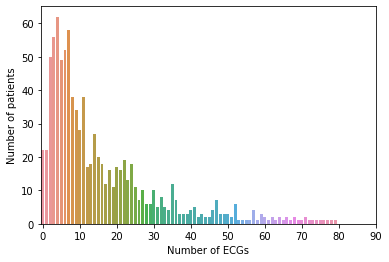

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x='NumEcgsTotal', data=clinical_df)
ax.set(xticks=np.arange(0,100,10), xticklabels=np.arange(0,100,10))
plt.xlabel('Number of ECGs')
plt.ylabel('Number of patients')
plt.show()

In [92]:
print('Total number of ECgs:', int(clinical_df['NumEcgsTotal'].sum()))
print('Number of ECGs before implant:', clinical_df['NumEcgsBeforeImplant'].sum())
print('Number of ECGs after implant:', clinical_df['NumEcgsAfterImplant'].sum())
print('Number of ECGs on day of implant:', clinical_df['NumEcgsOnImplantDay'].sum())
print(len(ecg_df))

Total number of ECgs: 16013
Number of ECGs before implant: 7062
Number of ECGs after implant: 8309
Number of ECGs on day of implant: 642
16058


In [80]:
print(len(clinical_df))
print(clinical_df['Therapy_during_FU'].value_counts())

917
No     543
Yes    372
         2
Name: Therapy_during_FU, dtype: int64


In [90]:
terechte_clinical_df = clinical_df.copy()
terechte_clinical_df['Terechte_therapie'] = 'No'
for i in range(1, 13):
    terechte_therapie_idx = terechte_clinical_df[f'Reason_ICD_therapy_{i}'] == 'Terechte therapie'
    terechte_clinical_df['Terechte_therapie'][terechte_therapie_idx] = 'Yes'
print(len(terechte_clinical_df))
print(terechte_clinical_df['Terechte_therapie'].value_counts())

917
No     625
Yes    292
Name: Terechte_therapie, dtype: int64


<ipython-input-90-198710245cda>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terechte_clinical_df['Terechte_therapie'][terechte_therapie_idx] = 'Yes'
